## dataload

In [4]:
import mlflow
import mlflow.lightgbm
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
import eli5
from eli5.sklearn import PermutationImportance
from shap import TreeExplainer, Explanation
from shap.plots import waterfall
import sys
sys.path.append('../LGBM')
from utils import custom_train_test_split, lgbm_predict, post_slack, title2filename
from xgboost import XGBClassifier
os.environ["LOGNAME"]='cwj'
SEED=13

## 1. 데이터 로딩
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'base_lgbm2.pkl')
df = pd.read_pickle(after_fe_path)

train_df = df[df.kind=='train']
train, valid1, valid2 = custom_train_test_split(train_df, ratio=0.7, seed=SEED) # 훈련데이터 split
test = df[df.kind=='test'] # 테스트 데이터
train2 = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
train = pd.concat([train,train2]) # 훈련데이터 병합
train.shape, valid1.shape, valid2.shape, test.shape

x_train = train.drop('answerCode',axis=1)
y_train = train[['answerCode']]

x_valid1 = valid1.drop('answerCode',axis=1)
y_valid1 = valid1[['answerCode']]

x_valid2 = valid2.drop('answerCode',axis=1)
y_valid2 = valid2[['answerCode']]

x_train.shape, y_train.shape, x_valid1.shape, y_valid1.shape, x_valid2.shape, y_valid2.shape

((1845539, 87), (680417, 87), (1974, 87), (260114, 87))

((1845539, 86), (1845539, 1), (680417, 86), (680417, 1), (1974, 86), (1974, 1))

In [38]:
# MLflow 연결
remote_server_uri="http://118.67.134.110:30005"
mlflow.set_tracking_uri(remote_server_uri)
client = mlflow.tracking.MlflowClient()
experiment_name = "XGBM"
try:
    experiment_id = client.create_experiment(experiment_name)
except:
    experiment = client.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
experiment_id

'162010768050295210'

In [ ]:
df[:3]

## XGBM 학습 및 예측

In [16]:
### 피처 설정
# 사용할 Feature 설정
xgbm_FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'assess_count',
         'elo_assessmentItemID',
         'elo_problem_num',
        ]

xgbm_cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
xgbm_cat_feats_idx = [i for i,e in enumerate(xgbm_FEATS) if e in xgbm_cat_feats]

xgbm_init_params = {
    "learning_rate": 0.023,
    "n_estimators" : 500,
}

xgbm_fit_params = {
    "categorical_feature" : xgbm_cat_feats_idx
}

In [17]:
model = XGBClassifier(**xgbm_init_params)

[0]	validation_0-auc:0.66499
[100]	validation_0-auc:0.69650
[200]	validation_0-auc:0.71995
[300]	validation_0-auc:0.72244
[400]	validation_0-auc:0.72464
[499]	validation_0-auc:0.72500


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.023, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

VALID AUC : 0.6745883325927022, ACC : 0.6722391084093212

writing prediction : output/12_08_Thu_XGBM_Test_피처_30개.csv


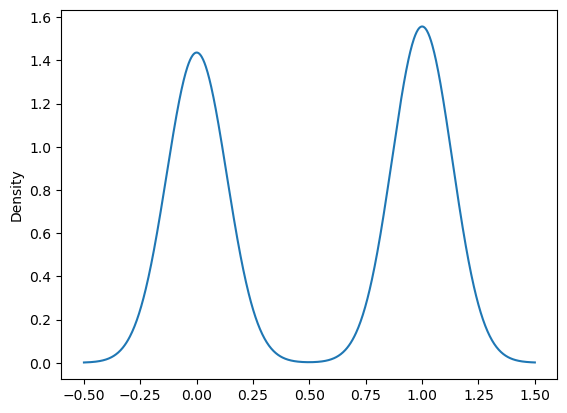

In [41]:
mlflow.xgboost.autolog()

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[XGBM Test] 피처: {len(xgbm_FEATS)}개"
using_feats=", ".join(xgbm_FEATS)
desc=f"사용된 피처({len(xgbm_FEATS)})\n{using_feats}"

with mlflow.start_run(run_name=title, description=desc,experiment_id=experiment_id) as run:
    model = XGBClassifier(**xgbm_init_params)
    model.fit(
        x_train[:1000][xgbm_FEATS],
        y_train[:1000],
        eval_set=[(x_valid2[xgbm_FEATS],y_valid2)],
        eval_metric="auc",
        verbose=100,
    )
    preds = model.predict(x_valid2[xgbm_FEATS])
    acc = accuracy_score(y_valid2, np.where(preds >= 0.5, 1, 0))
    auc2 = roc_auc_score(y_valid2, preds)
    print(f'VALID AUC : {auc2}, ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc2)
    mlflow.log_metric("VAL Set SEED",SEED)
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model, xgbm_FEATS, f'{file_name}.csv')
    
q = pd.Series(test_preds).plot(kind='kde')

In [24]:
perm = PermutationImportance(
    model, scoring="roc_auc", n_iter=1, random_state=42, cv=None, refit=False
).fit(x_valid2[xgbm_FEATS], y_valid2)
eli5.show_weights(perm, top=len(xgbm_FEATS), feature_names=xgbm_FEATS)

Weight,Feature
0.0251 ± 0.0000,solvesec_cumsum
0.0195 ± 0.0000,mid_category_cumconut
0.0162 ± 0.0000,elo_assessmentItemID
0.0144 ± 0.0000,mid_category
0.0108 ± 0.0000,assIdx
0.0097 ± 0.0000,dayname
0.0086 ± 0.0000,test_mean
0.0080 ± 0.0000,day
0.0054 ± 0.0000,user_total_answer
0.0051 ± 0.0000,KnowledgeTag
